# Quantifying the Moment of Learning
## Goal
We aim to determine when an animal successfully learns to detect microstimulation. Specifically, we want to discover whether learning occurs overnight (at the start of a session) or during the session itself. We use four key metrics—P(Hit), D', response time, and variance of response time—to classify learning and identify how many trials it takes for an animal to learn. Monte Carlo simulations will help us assess the probability of different learning outcomes.

## Performance Metrics & Thresholds
- **P(Hit)**: The probability of correctly detecting microstimulation. An animal is considered an expert if its hit rate exceeds 80%.
- **D'**: Sensitivity index accounting for random licks. A threshold of 1.5 is sufficient for impulsive animals, while more patient ones might reach values above 3.
- **Response Time**: Expected to decrease as the animal learns the task.
- **Variance of Response Time**: Decreases as behavior becomes more stereotyped, indicating consistent performance.

## Steps for analysis
1. Read BPOD data into the Mouse_Data Class
2. Calculate the metrics
3. Visualize the progression of these metrics over all trials
4. Determine when the threshold is surpassed
5. Monte Carlo Simulation


In [6]:
'''STEP 1: Read in data and import necessary functions'''
from Mouse_Data import Mouse_Data
from helpers import *
from visualization import *
import scipy as sp

# Path to data
root = 'D:/mStim_data/'

IDs = ['SNA-123598', 'SNA-123602', 'SNA-123599', 'SNA-126687', 'SNA-126688', 'SNA-127100', 'SNA-132298', 'SNA-132303', 'SNA-132305'] # SNA-123601 leaned immediately so removed has trials that need to be removed in 2nd and 4th session
data = [Mouse_Data(root + ID +'/') for ID in IDs]

Data will be concatenated; please check validity.
Data will be concatenated; please check validity.
Data will be concatenated; please check validity.


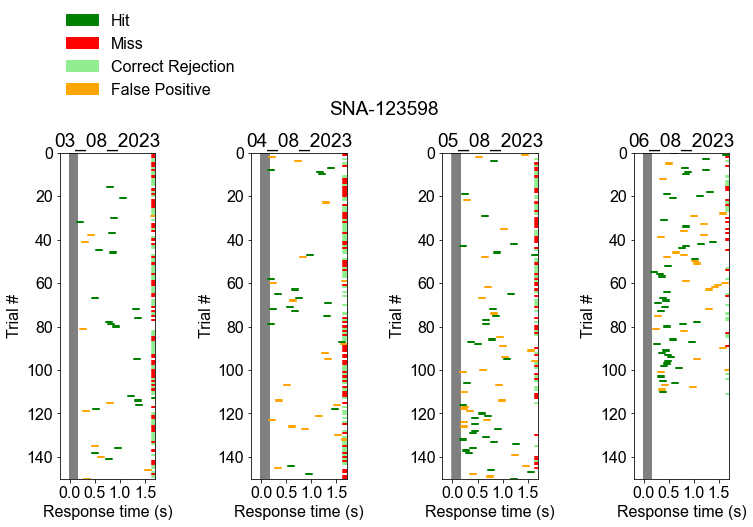

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


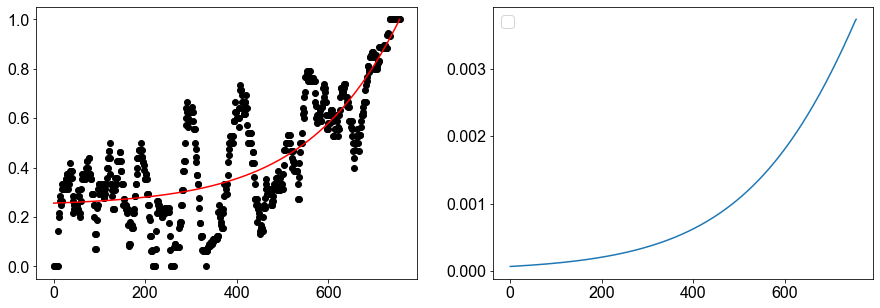

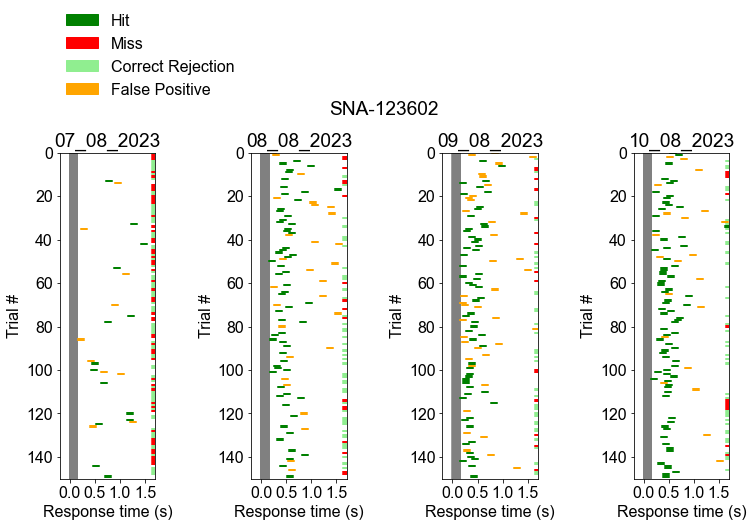

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


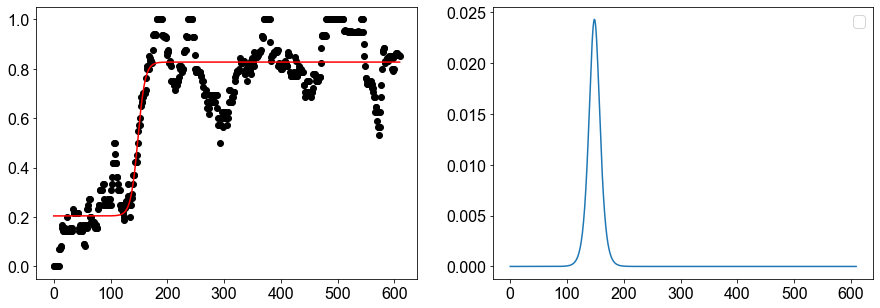

C:\Users\miksc\AppData\Local\Temp\ipykernel_23540\2784601932.py:15: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0))) + b


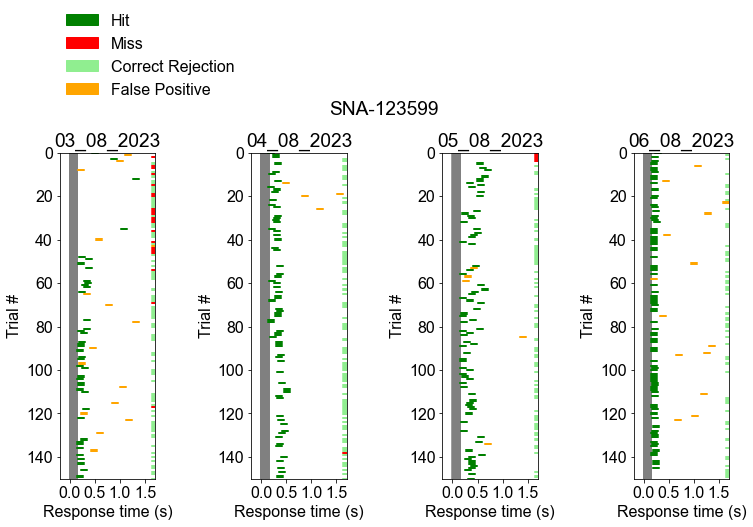

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


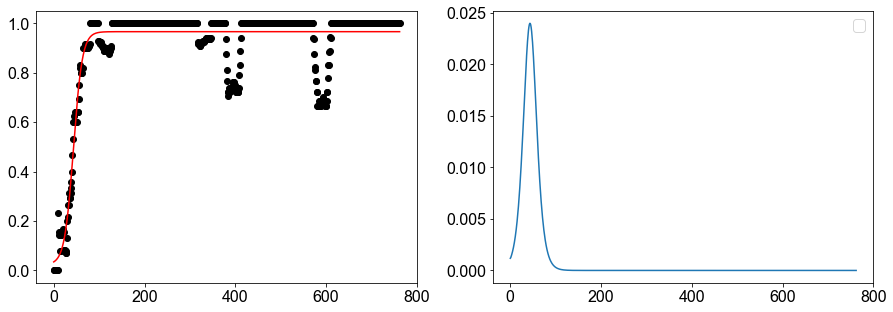

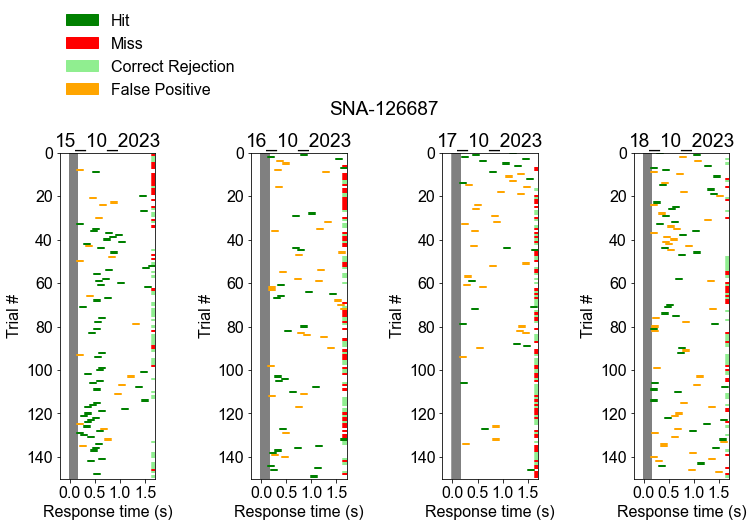

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


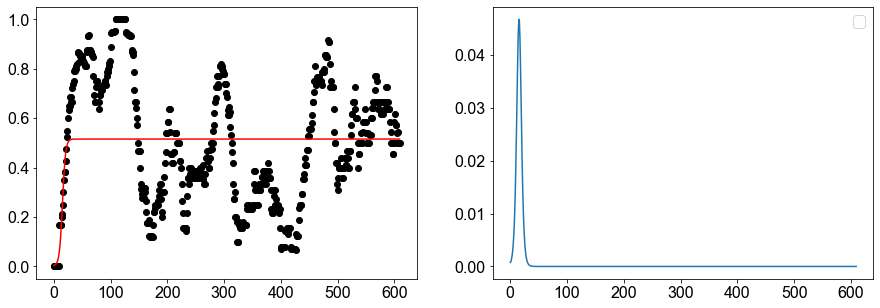

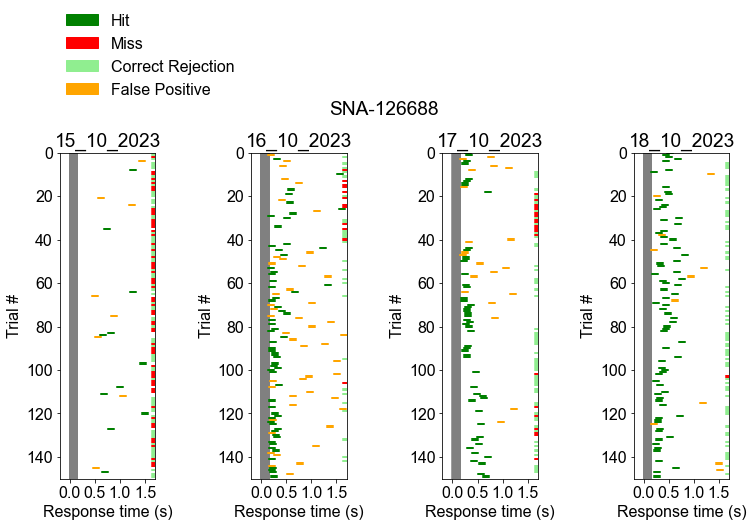

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


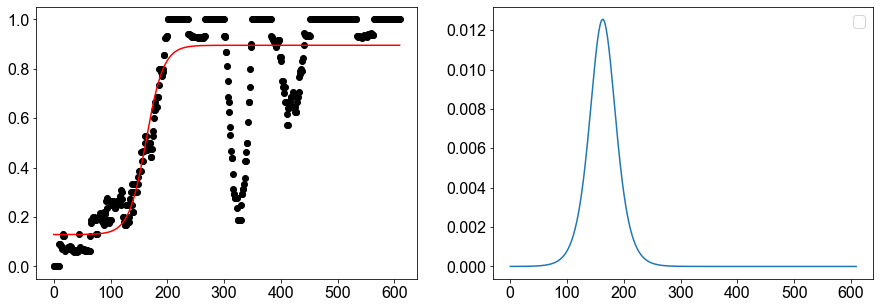

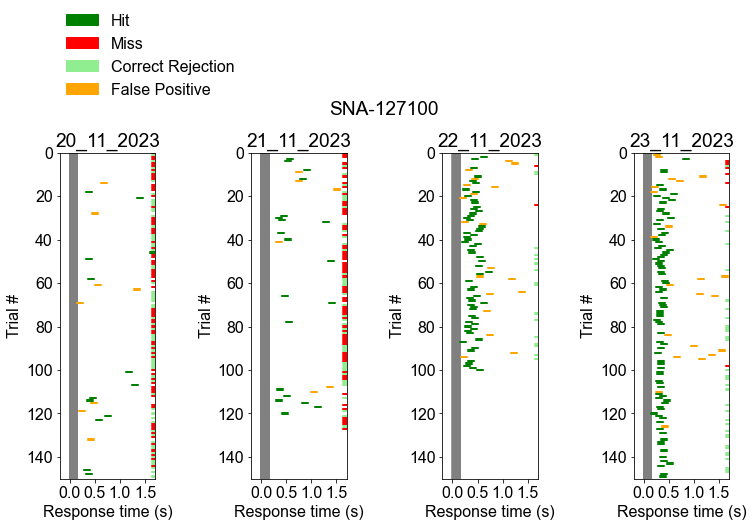

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


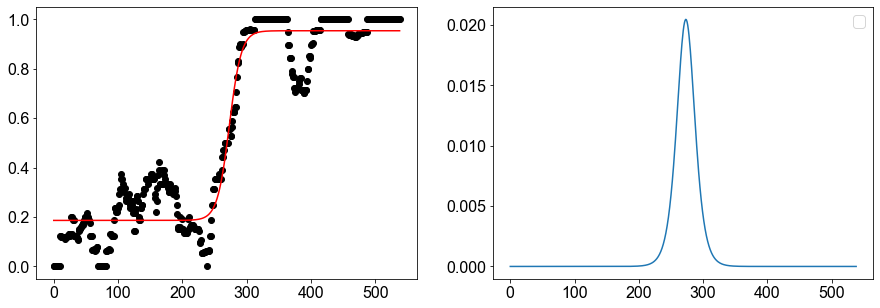

C:\Users\miksc\AppData\Local\Temp\ipykernel_23540\2784601932.py:15: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0))) + b


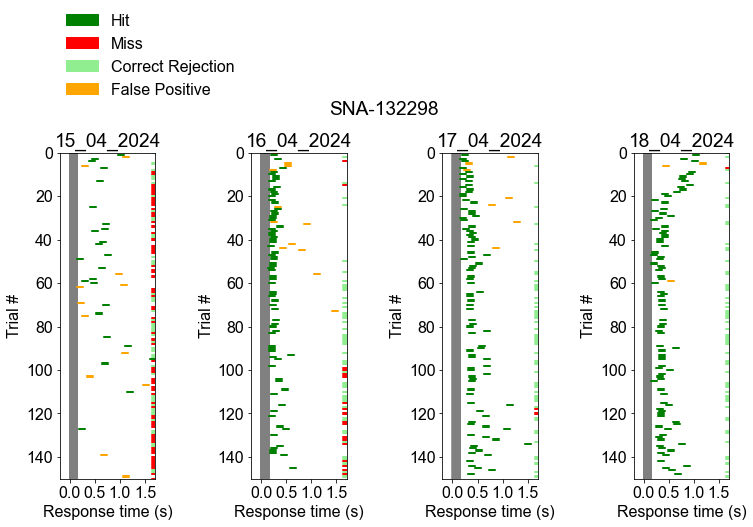

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


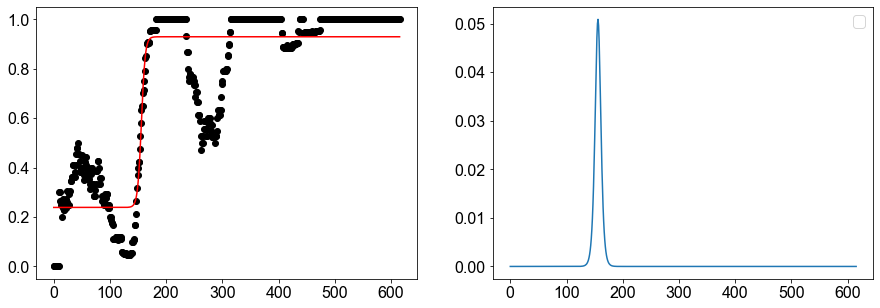

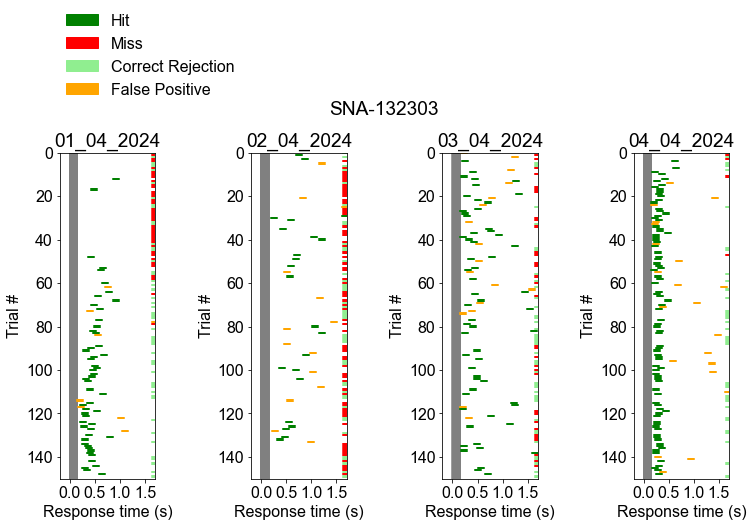

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


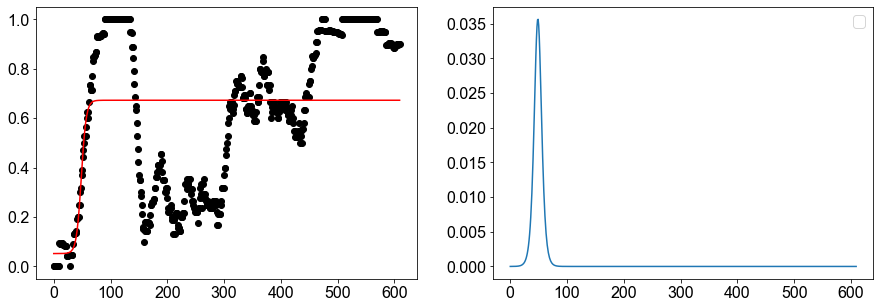

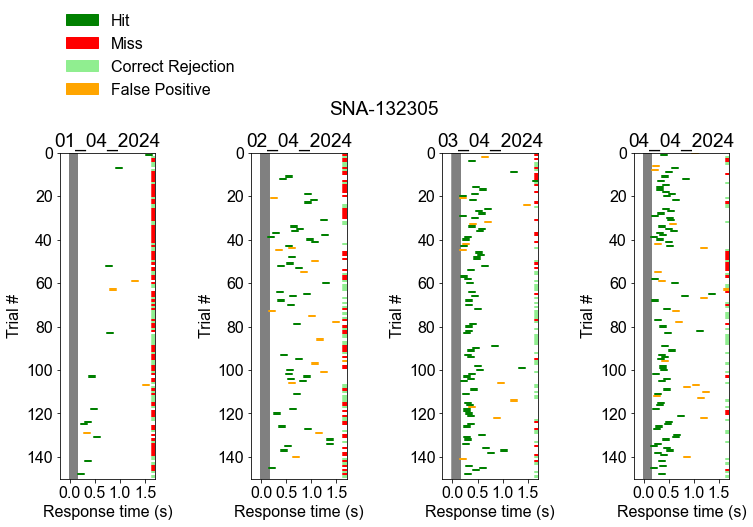

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


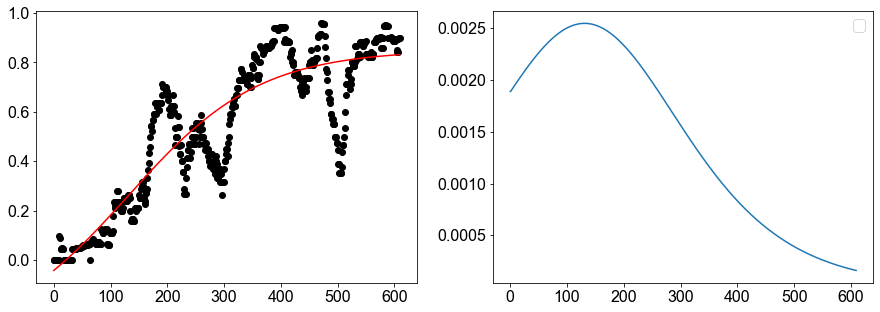

In [7]:
'''STEP 2: calculate the metrics'''
binsize = 30

for mouse in data:
    Plick, _ = get_PLick(mouse, binsize=binsize) # mStim_Plick only contains microstim trials
    Plick = [0]*10 + Plick
    d_prime = calc_d_prime(mouse, binsize=binsize) # Contains all trials
    RTs = get_RT(mouse.full_data, 1, binsize=binsize) # Contains only hit trials
    sem = get_SEM(RTs, binsize=binsize) # Contains only hit trials


    '''STEP 3: Visualize the metrics over all trials'''
    # Step 1: Define the sigmoidal function (logistic function)
    def sigmoid(x, L, x0, k, b):
        return L / (1 + np.exp(-k * (x - x0))) + b

    # Step 2: Prepare your data (replace with your actual data)
    # x_data = np.linspace(0, len(Plick), 100)  # Example x data
    x_data = np.arange(0, len(Plick), 1)
    y_data = Plick
    # y_data = sigmoid(x_data, 1, 5, 1, 0) + 0.05 * np.random.normal(size=len(x_data))  # Example noisy y data

    # Step 3: Fit the sigmoidal function to your data
    popt, pcov = curve_fit(sigmoid, x_data, y_data, p0=[1, 5, 1, 0])



    plot_raster_rt(mouse)

    # Step 4: Plot the original data and the fitted sigmoidal function
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.scatter(x_data, y_data, label='Data', color='black')
    ax1.plot(x_data, sigmoid(x_data, *popt), label='Fitted sigmoid', color='red')

    # Also get the derivative, indicating the speed of change. This should be highest at the moment of learning.
    der = np.gradient(sigmoid(x_data, *popt))
    peak_idx = np.argmax(der)
    ax2.plot(der)
    plt.legend()
    plt.show()

In [6]:
def find_threshold_crossing(data, binsize=30, threshold_dict={'PLick':0.8,'d_prime':2,'RT':0.4,'sem':0.01}, start_idx=10):
    ''' Find the absolute trial at which a performance threshold is crossed. We use a sliding window of computed metrics. 

    INPUT:
        data (Mouse_Data): The Mouse_Data base class
        binsize (int): how big is the sliding window

    OUTPUT:
        corssing_dict: dictionary containing the trial number where each threshold was crossed.
        If a threshold is not crossed, the value will be `np.nan`.
    '''
    # TODO fix the fuckery with mouse versus mouse.full_data also the name data sucks
    # From the data get all metrics of importance: Plick, d', RT and sem of RT
    Plick, _ = get_PLick(data, binsize=binsize) # mStim_Plick only contains microstim trials
    d_prime = calc_d_prime(data, binsize=binsize) # Contains all trials
    RTs = get_RT(data.full_data, 1, binsize=binsize) # Contains only hit trials
    sem = get_SEM(RTs, binsize=binsize) # Contains only hit trials

    # Now that we have all the values determine when the threshold (from threshold dict) is crossed
    # It's important to note that this crossing does not correspond to a trialnumber because not all trials are taken into account for the metric
    PLick_thresh = np.where(np.array(Plick[start_idx:]) >= threshold_dict['PLick'])[0] # Because we are not looking at the first start_idx trials 
    dp_thresh = np.where(np.array(d_prime[start_idx:]) >= threshold_dict['d_prime'])[0]
    RT_thresh = np.where(np.array(RTs[start_idx:]) <= threshold_dict['RT'])[0]
    sem_thresh = np.where(np.array(sem[start_idx:]) <= threshold_dict['sem'])[0]

    # Now that we have the indexes where the values have been crossed let's pinpoint this to a trial number
    stim_data = select_trialType(data.full_data, 1)
    hit_data = stim_data.loc[stim_data['success'] == True]

    # Check if the threshold has been crossed at all
    crossing_dict = {}
    for metric, name in zip([PLick_thresh, dp_thresh, RT_thresh, sem_thresh],['PLick', 'd_prime','RT', 'sem']):
        if len(metric) == 0:
            # print(f'{name} Threshold of {threshold_dict[name]} has not been crossed')
            crossing_dict[name] = np.nan
        else:
            if name == 'PLick':
                crossing_dict[name] = data.full_data.iloc[metric[0] + start_idx].name
            elif name == 'd_prime':
                crossing_dict[name] = dp_thresh[0] + start_idx
            elif name == 'RT':
                crossing_dict[name] = hit_data.iloc[RT_thresh[0] + start_idx].name
            elif name == 'sem':
                crossing_dict[name] = hit_data.iloc[sem_thresh[0] + start_idx].name

    return crossing_dict

def find_session_threshold(mouse, threshold_trial):
    ''' Find how many trials into a session the trial at which the crossing happened occured.

    OUTPUT:
        session(str), trials_into_session(int)
    '''
    # Get the row of interest
    session_data_dict = mouse.session_data

    # Go through all the session_data in the dictionary
    trials_passed = 0
    for session, df in session_data_dict.items():
        # Count the number of rows
        all_trials = np.array(df.index.to_list()) + trials_passed

        # Try to determine if the trial at which learning occured is in this session
        if threshold_trial in all_trials:
            trials_into_session = threshold_trial - all_trials[0]
            return session, trials_into_session

        # Else check out the next session and check if the trial number was there 
        trials_passed = all_trials[-1] +1 
    return None, None
    


# Issues to solve
1. Check at least for P(hit), d' and RT if where the threshold was crossed is accurate

## Notes from meeting
* Create plots for all metrics over all trials for each animal
    * Also have a smoothed version of the data or a fit?
* Plot the derivative of the performance and get when it peaks to determine the moment of leaning
    * However, even if the peak of the derivative is somewhere there has to be a baseline performance met
* Get a value that is something like: if(hit) / trial_till_next hit / response time. 
    * This will be a measure for consecutive hits with a low response time creating a higher value
    

# TLDR
What I basically need to do is:
1. For all trials calculate the (binned) hit %, RT, variance in RT and d' 
    * Set a threshold for these metrics that are telling of an animal that has learned
2. Determine on how many trials into a new session this threshold is crossed
3. Do Monte carlo simulation?

## STEP 1: Read in data and import functions


## STEP 2: Calculate metrics
* Hit %
* D '
* Response time
* SEM of response time

## STEP 3
Determine where the threshold is crossed (which trial). It would be really nice if this could be combined into a single value

Threshold:
1. Plick >0.8
2. D' > 2
3. RT < 0.5
4. RT_sem < 0.01


## Monte Carlo Simulations:
A Monte Carlo simulation is a computational technique used to model the probability of different outcomes in processes that are uncertain or random. The method relies on repeated random sampling to obtain numerical results. It’s especially useful for situations where it is difficult or impossible to predict the outcome due to the complexity or inherent randomness of the system.
* Generate a large number of simulated datasets (e.g., 10,000 simulations).
* For each simulation, randomly generate performance for each trial in each session, based on the distribution you established.
* Record the performance increase (or decrease) from one session to the next for each simulated mouse.

In [7]:
def Monte_Carlo(sample, threshold, num_simulations=25000):
    '''docstring
    INPUT
        sample should be an array 
        threshold should be an interger that corresponds to the number of trials that determines as early learning or begin of session learning
    '''
    # Perform the Monte Carlo simulation
    simulation_results = []
    for _ in range(num_simulations):
        # Resample with replacement
        simulated_sample = np.random.choice(sample, size=150, replace=True)
        # Calculate the proportion of animals that learned within the threshold
        proportion_learned = np.mean(simulated_sample <= threshold)
        simulation_results.append(proportion_learned)

    # Convert results to a Pandas Series for easier analysis
    simulation_results = pd.Series(simulation_results)

    # Calculate the probability of learning within the time threshold
    probability = simulation_results.mean()
    return simulation_results, probability

['SNA-123598', 'SNA-123602', 'SNA-123599', 'SNA-126687', 'SNA-126688', 'SNA-127100', 'SNA-132298', 'SNA-132303', 'SNA-132305']
Computed mean cross from start [150, 30, 10, 45, 150, 40, 10, 10, 70, 30]
Computed mean cross from start [159, 49, 54, 42, 70, 2, 126, 22, 44]


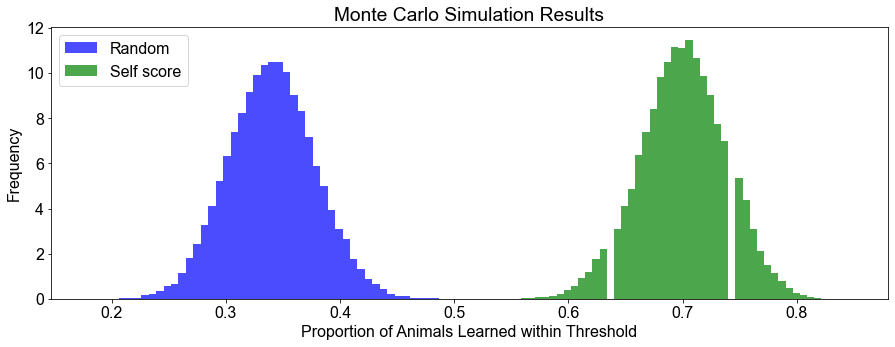

In [8]:
# Now combine it all together learning_from_start = []
learning_from_start = []
thresholds = []
for mouse in data:
    crossings = find_threshold_crossing(mouse)
    crossings = list(crossings.values())
    threshold = int(np.nanmean(crossings))
    learning_from_start.append(find_session_threshold(mouse, threshold)[1])

# For now let's set the cap for early session learning at 50 
start_threshold = 50
num_simulations = 20000
learning_any_day = 150 

data_results, data_prob = Monte_Carlo(learning_from_start, start_threshold)
my_results, my_prob = Monte_Carlo([150, 30, 10, 45, 150, 40, 10, 10, 70, 30], start_threshold)
sim_results, sim_prob = Monte_Carlo(np.arange(150), start_threshold)


print(IDs)
print(f'Computed mean cross from start [150, 30, 10, 45, 150, 40, 10, 10, 70, 30]')
print(f'Computed mean cross from start {learning_from_start}')

# Optional: Plot the distribution of the simulation results
plt.figure(figsize=(15,5))
plt.hist(sim_results, bins=50, density=True, alpha=0.7, color='blue', label='Random')
plt.hist(my_results, bins=50, density=True, alpha=0.7, color='green', label='Self score')
# plt.hist(data_results, bins=50, density=True, alpha=0.7, color='red', label='Comp score')
plt.legend(loc='upper left')


plt.title('Monte Carlo Simulation Results')
plt.xlabel('Proportion of Animals Learned within Threshold')
plt.ylabel('Frequency')
plt.show()

[113]
[41]


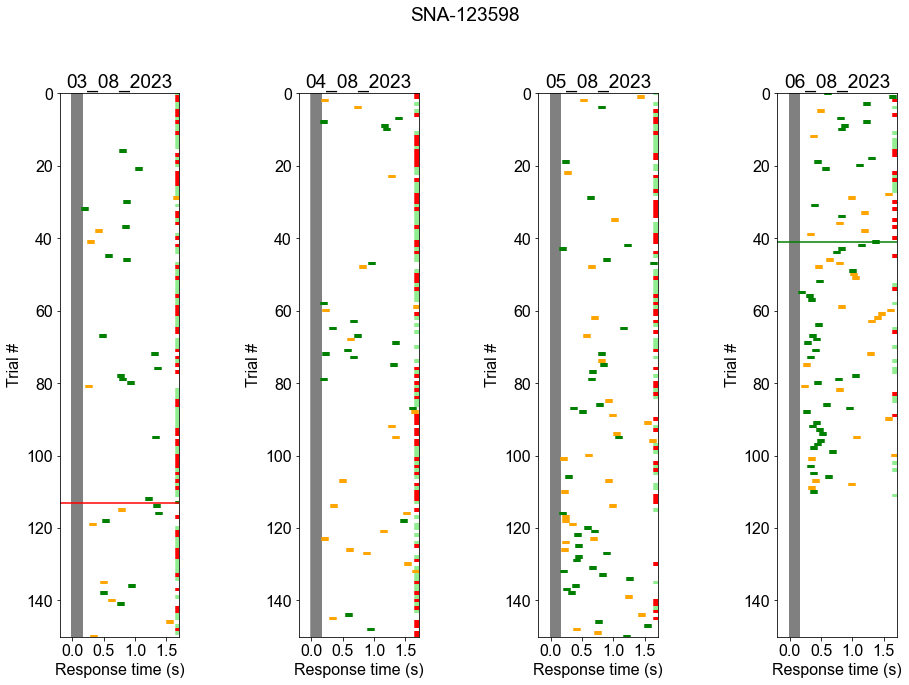

In [18]:
''''This is just a rasterplot with added lines that show where a threshold was crossed'''
def plot_raster_rt(mouse_data, threshold_dict, save=False, peak=False):
        ''' Creates a figure containing rasterplots of the trial response time.

            INPUT:
                mouse_data(Mouse_Data): Dataclass with attributes like id, sessions,.session_data and concatenated data
                save(bool): prompts the user for destination folder path
                peak(bool): if true only two session rasterplots will be created
            OUTPUT:
                raster_rt_plot(matplotlib.plt): either a plot is shown or saved
        '''
        # Check for peaking allowing the user to only see the plots of the first 2 sessions
        if peak:
            n_sessions = 2
        else:
            n_sessions = len(mouse_data.sessions)
        # Set figure basics 
        fig, axs = plt.subplots(1, n_sessions, figsize=(15, 10)) # Size plot according to the number of sessions
        plt.subplots_adjust(wspace=1.) 
        fig.patch.set_facecolor('white')
        fig.suptitle(str(mouse_data.id), y=1.0)
        
        # Create legend patches
        # gray_patch = matplotlib.patches.Patch(color='gray', label='Stimulus')
        orange_patch = matplotlib.patches.Patch(color='orange', label='False Positive')
        red_patch = matplotlib.patches.Patch(color='red', label='Miss')
        green_patch = matplotlib.patches.Patch(color='green', label='Hit')
        lightgreen_patch = matplotlib.patches.Patch(color='lightgreen', label='Correct Rejection')
        
        # Get and plot data for every session
        for idx, session in enumerate(mouse_data.sessions):
            if peak and idx == n_sessions:
                break
            colors = []


            # For pairing only pair and mix data are important
            # if catch:
            select_data = mouse_data.session_data[session].loc[(mouse_data.session_data[session]['trialType'] == 2)|(mouse_data.session_data[session]['trialType'] == 1)|(mouse_data.session_data[session]['trialType'] == 'pairData')]        
            patches = [green_patch, red_patch, lightgreen_patch, orange_patch]
            
            # Aquire response time, xticks and datatype
            rt_full = select_data['response_t']
            x = np.arange(0, len(rt_full), 1) # Initiate x-axis for plotting
            rt = [[rt] for rt in rt_full] # plt.eventplot requires values as list to ascribe different offsets
            # dtype = [[dtype] for dtype in select_data['trialType']]

            # Pick right color
            for _, trial in select_data.iterrows():
                trial_success = trial['success']
                if trial['trialType'] == 2:
                    if trial_success:
                        c = 'orange'
                    else:
                        c='lightgreen'
                elif trial['trialType'] == 1:
                    if trial_success:
                        c = 'green'
                    else:
                        c = 'red'
                        
                colors.append(c)
                
            # Now the plot
            # If there are multiple sessions
            if len(mouse_data.sessions) > 1:
                for x in np.arange(0, 0.15, 0.001):
                    axs[idx].axvline(x, color='gray')
                offset = np.arange(0, len(rt), 1)
                axs[idx].eventplot(rt, lineoffsets=offset, linewidth=7.5, colors=colors)
                axs[idx].set_xlim([-0.2, 1.71])
                axs[idx].set_ylabel('Trial #')
                axs[idx].invert_yaxis()
                axs[idx].set_ylim([150, 0])
                axs[idx].set_xlabel('Response time (s)')
                axs[idx].set_title(str(session))
                axs[idx].set_xticks(np.arange(0, 1.55, 0.5))
                # axs[0].legend(bbox_to_anchor=(0., 1.15, 1., .02), handles=patches, mode="expand", borderaxespad=0., ncol=1, frameon=False)

                # NOTE FOR LEARNING CHECK
                # Check if something happened during this session
                if session in threshold_dict['session']:
                    # x = threshold_dict['session'].index(session)
                    xs = [i for i,s in enumerate(threshold_dict['session']) if s == session]
                    cs = [metric_colors[x] for x in xs]
            
                    # So now for these session get the trials
                    trials = [threshold_dict['trial'][x] for x in xs]
                    print(trials)
                    # Now plot a marker
                    [axs[idx].axhline(trial, color=c) for trial, c in zip(trials,cs)]
            
            # If there is just one sessions
            else:
                for x in np.arange(0, 0.15, 0.001):
                    axs.axvline(x, color='gray')
                offset = np.arange(0, len(rt), 1)
                axs.eventplot(rt, lineoffsets=offset, linewidth=7.5, colors=colors)
                axs.set_xlim([-0.2, 1.71])
                axs.set_ylabel('Trial #')
                axs.invert_yaxis()
                axs.set_xlabel('Response time (s)')
                axs.set_title(str(session))
                axs.legend(bbox_to_anchor=(0., 1.15, 1., .102), handles=patches, mode="expand", borderaxespad=0., ncol=1, frameon=False)
        
            

        # Prompt user for destination folder path or show the plot
        if save:
            fname = input('What path do you want to save the .jpg to?')
            fig.savefig(fname+mouse_data.id+'.jpg', bbox_inches='tight')   
        else:   
            plt.show()
        return

for mouse in data:
    # Find where the threshold is crossed
    absolute_crossing = find_threshold_crossing(mouse)

    # So for each of the metrics find how many trials into the session it occured
    metrics = list(absolute_crossing.keys())
    relative_crossing=[]
    session_crossing=[]
    for trial in absolute_crossing.values():
        session, trial_from_start = find_session_threshold(mouse, trial)
        relative_crossing.append(trial_from_start)
        session_crossing.append(session)

    d = {'metrics':metrics, 'session':session_crossing,'trial':relative_crossing}
    metric_colors = ['green', 'black', 'blue', 'red']

    plot_raster_rt(mouse, d)
    break
